# MLB Data Analysis
1. Problem definition
2. Acquire data
3. Data cleaning
4. Feature Selection
5. Exploratory Data Analysis
6. Build Model and explain the performance
7. Submit the results.

## 1. Probelm definition
> Predict pitch name based on other variables

In [56]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import math
import os


In [2]:
# %pwd
# os.chdir('/Users/kylecamlic/Documents')
# %pwd

## 2. Acquire Data

In [3]:
df = pd.read_csv("statcast_2017.csv")

In [4]:
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,FC,2017-10-01,91.9,-1.19,5.99,"Osuna, Roberto",595885,532077,field_out,...,2,2,1,1,2,Infield shift,Strategic,183.0,-0.044,-0.124
1,2350,FC,2017-10-01,91.8,-1.08,6.18,"Osuna, Roberto",595885,532077,NaN,...,2,2,1,1,2,Infield shift,Strategic,164.0,-0.044,-0.035
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,NaN,...,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
3,2485,CH,2017-10-01,82.8,-0.99,6.06,"Osuna, Roberto",595885,532077,NaN,...,2,2,1,1,2,Infield shift,Strategic,226.0,-0.044,0.020
4,2666,FT,2017-10-01,95.9,-0.89,6.13,"Osuna, Roberto",595885,532077,NaN,...,2,2,1,1,2,Infield shift,Strategic,221.0,-0.044,0.014


## 3. Data Cleaning

pitch_name     
4-Seam Fastball    0.347745
Slider             0.162316
2-Seam Fastball    0.129517
Changeup           0.099332
Sinker             0.078767
Curveball          0.078671
Cutter             0.053005
Knuckle Curve      0.029668
Split-Finger       0.016476
Knuckleball        0.003685
Forkball           0.000344
Eephus             0.000258
Pitch Out          0.000162
Screwball          0.000054
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

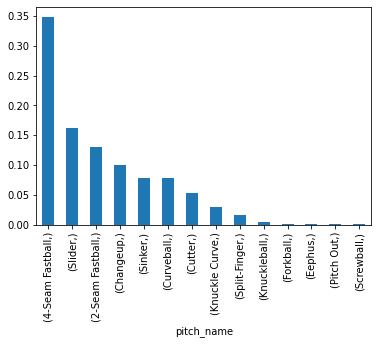

In [5]:
print(df[['pitch_name']].value_counts(normalize= True))
df[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

From above we can see 14 types of pitch. For more accurate result, we drop 5 infrequent types, Knuckleball, Forkball, Eephus, Pitch Out and Screwball

In [6]:
#Get rid of Knuckleball, Forkball, Eephus, Pitch Out and Screwball

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
    
values = ['Knuckleball','Forkball','Eephus','Pitch Out','Screwball']
print(f'size before removing 5 pitch name {df.shape}')
df = filter_rows_by_values(df,'pitch_name', values)
print(f'size after removing 5 pitch name {df.shape}')

size before removing 5 pitch name (721244, 93)
size after removing 5 pitch name (718011, 93)


In [7]:
# drop columns with high null rate (60%)
print(f"shape of df before dropping high null columns {df.shape}")
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
print(f"shape of df after dropping high null columns {df.shape}")

# get rid of all null rows
print(f"size before droping high null columns {df.shape}")
df = df.dropna()
print(f"size after droping high null columns {df.shape}")

shape of df before dropping high null columns (718011, 93)
shape of df after dropping high null columns (718011, 67)
size before droping high null columns (718011, 67)
size after droping high null columns (700635, 67)


In [8]:
# change the data type of batter from int to string for future training purpose
df['batter'] = df['batter'].astype("str")

## 4. Feature Selection

In this section, we would like to select variables that has correlation with our target variable.

We split into two part. 

1) Choose K Best categorical variables 
2) Choose K Best numerical variables 

Reference : https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

**Choose K Best Categorical Variables**

Pearson’s Chi-Squared Test

The Chi-Squared test does this for a contingency table, first calculating the expected frequencies for the groups, then determining whether the division of the groups, called the observed frequencies, matches the expected frequencies. When observed frequency is far from the expected frequency, the corresponding term in the sum is large; when the two are close, this term is small. Large values of X^2 indicate that observed and expected frequencies are far apart. Small values of X^2 mean the opposite: observeds are close to expecteds. So X^2 does give a measure of the distance between observed and expected frequencies

The variables are considered independent if the observed and expected frequencies are similar, that the levels of the variables do not interact, are not dependent.

The Pearson’s chi-squared test for independence can be calculated in Python using the chi2_contingency() SciPy function.

For example, a probability of 95% can be used, suggesting that the finding of the test is quite likely given the assumption of the test that the variable is independent. If the statistic is less than or equal to the critical value, we can fail to reject this assumption, otherwise it can be rejected.

We can also interpret the p-value by comparing it to a chosen significance level, which would be 5%, calculated by inverting the 95% probability used in the critical value interpretation.

In [9]:
df_categorical = df.select_dtypes(exclude=["number"])
df_categorical.describe()

,pitch_type,game_date,player_name,batter,description,des,game_type,stand,p_throws,home_team,away_team,type,inning_topbot,pitch_name,if_fielding_alignment,of_fielding_alignment
count,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635,700635
unique,9,179,753,957,12,123247,1,2,2,30,30,3,2,9,3,4
top,FF,2017-09-02,"Verlander, Justin",592450,ball,Khris Davis strikes out swinging.,R,R,R,BOS,BOS,S,Top,4-Seam Fastball,Standard,Standard
freq,248751,5215,3524,2889,237431,644,700635,409812,518327,24705,24316,321429,356439,248751,554768,652508


In [10]:
# add batter ID
df_categorical['batter'] = df.batter.astype(str)

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_63669/1831782859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical['batter'] = df.batter.astype(str)


We drop the columns that is not contributing to predict pitch_name.

In [11]:
Y_categorical = df_categorical.pitch_name
X_categorical = df_categorical.drop(['des','game_type','pitch_type','pitch_name'], axis = 1)
X_columns = X_categorical.columns


In [12]:
oe = OrdinalEncoder()
oe.fit(X_categorical)
X_categorical = oe.transform(X_categorical)
X_categorical

array([[178., 499., 690., ...,   0.,   0.,   3.],
       [178., 499., 690., ...,   0.,   0.,   3.],
       [178., 499., 690., ...,   0.,   0.,   3.],
       ...,
       [  0., 414., 943., ...,   1.,   1.,   2.],
       [  0., 414., 943., ...,   1.,   1.,   2.],
       [  0., 414., 943., ...,   1.,   1.,   2.]])

In [13]:
# prepare target
le = LabelEncoder()
le.fit(Y_categorical)
Y_categorical = le.transform(Y_categorical)

In [14]:
fs = SelectKBest(score_func=chi2, k="all")
fs.fit(X_categorical, Y_categorical)
print(X_categorical.shape)
X_categorical = fs.transform(X_categorical)


(700635, 12)


Feature game_date: 3102.625799
Feature player_name: 244435.245938
Feature batter: 12348.884340
Feature description: 9247.783960
Feature stand: 2508.282408
Feature p_throws: 1498.419436
Feature home_team: 3677.409632
Feature away_team: 2314.145058
Feature type: 779.396475
Feature inning_topbot: 63.081745
Feature if_fielding_alignment: 147.664196
Feature of_fielding_alignment: 5.743658


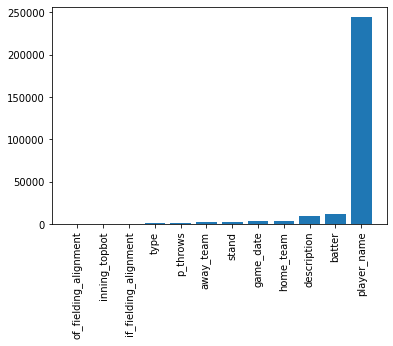

In [15]:
# what are scores for the features
score_dict = {}
for i in range(len(fs.scores_)):
	print(f'Feature {X_columns[i]}: %f' % (fs.scores_[i]))
	score_dict[X_columns[i]] = fs.scores_[i]
	
# plot the scores
score_dict = dict(sorted(score_dict.items(), key=lambda item: item[1]))
plt.bar(score_dict.keys(), score_dict.values())
plt.xticks(rotation = 90)
plt.show()

**Choose K Best Numerical Variables**

ANOVA feature selection for numeric input and categorical output

In [16]:
# Choose X
X_numerical = df.select_dtypes(include=np.number)
Y_numerical = df.pitch_name
print(X_numerical.columns)

Index(['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z',
       'pitcher', 'zone', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'outs_when_up', 'inning', 'fielder_2', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'at_bat_number',
       'pitch_number', 'home_score', 'away_score', 'bat_score', 'fld_score',
       'post_away_score', 'post_home_score', 'post_bat_score',
       'post_fld_score', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')


In [17]:
X_numerical = X_numerical.drop(['Unnamed: 0', 'pitcher'], axis = 1)

In [18]:
# Create and fit selector
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_numerical, Y_numerical)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X_numerical.iloc[:,cols]
X_new

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,release_speed,release_pos_z,pfx_x,pfx_z,plate_z,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis
0,91.9,5.99,-0.06,1.54,3.25,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,91.0,2422.0,5.9,54.56,183.0
1,91.8,6.18,0.31,1.17,2.88,-133.448994,-4.998474,3.013840,26.852669,-17.455348,91.5,2415.0,6.0,54.49,164.0
2,94.7,6.34,-0.27,1.84,2.76,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,94.2,2450.0,6.1,54.37,189.0
3,82.8,6.06,-1.27,1.38,0.80,-120.061310,-8.130244,-13.056935,22.889681,-17.553809,82.6,2063.0,6.3,54.21,226.0
4,95.9,6.13,-1.19,1.50,0.87,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,95.8,2554.0,6.3,54.17,221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721239,98.4,5.15,-1.28,0.68,1.83,-142.581131,-4.918857,-18.573869,33.201434,-22.306689,96.7,2066.0,5.5,54.92,246.0
721240,84.6,5.39,1.10,-0.17,1.94,-122.821485,-1.341576,10.331882,24.074272,-33.798336,82.3,2194.0,4.7,55.68,74.0
721241,97.3,5.18,-1.34,0.55,1.33,-141.192269,-5.944415,-18.881798,30.681296,-23.942620,96.2,2015.0,5.6,54.80,252.0
721242,95.9,5.48,-1.59,0.84,2.32,-139.217803,-4.486852,-21.233172,30.974374,-20.788933,94.2,2144.0,5.5,55.07,245.0


Feature release_speed: 245271.87340196123
Feature release_pos_z: 3020.8921179306517
Feature pfx_x: 14417.317493035243
Feature pfx_z: 216998.80144434262
Feature plate_z: 12163.929447732784
Feature vy0: 240952.59072991056
Feature vz0: 30804.33385938965
Feature ax: 13091.994370901144
Feature ay: 91718.86561500122
Feature az: 239421.88110344447
Feature effective_speed: 229706.88773162512
Feature release_spin_rate: 72129.49177046007
Feature release_extension: 11259.13459804743
Feature release_pos_y: 11330.133899855335
Feature spin_axis: 16729.61980981074


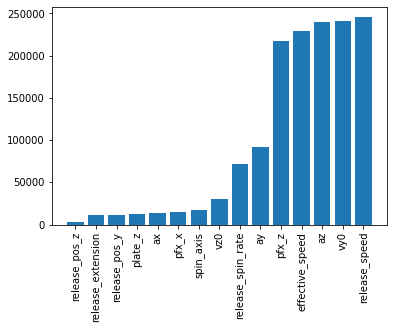

In [19]:
input_features = selector.feature_names_in_
score_dict = {}
for i in range(len(selector.get_feature_names_out())):
    name = selector.get_feature_names_out()[i]
    score = selector.scores_[list(input_features).index(name)]
    score_dict[name] = score
    print(f'Feature {name}: {score}')
# plot the scores
score_dict = dict(sorted(score_dict.items(), key=lambda item: item[1]))
plt.bar(score_dict.keys(), score_dict.values())
plt.xticks(rotation = 90)
plt.show()

## 5.  Exploratory Data Analysis

We will first start with PCA to see whether pitch_name is seperable

In [20]:
# choose the columns that we chose earlier in the meeting
df_pca = df[['pitch_name','release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate']]

In [21]:
# drop all the null values before running PCA
print(f"size before droping null values {df_pca.shape}")
df_pca = df_pca.dropna()
print(f"size after droping null values {df_pca.shape}")

size before droping null values (700635, 5)
size after droping null values (700635, 5)


In [22]:
# Choose 1,000 samples and run PCA to see whether there are clusters
df_pca = df_pca.sample(n=1000, random_state=1)
df_pca_X = df_pca.drop('pitch_name',axis = 1)

pca = PCA(n_components=2)
components = pca.fit_transform(df_pca_X)

In [23]:
print(pca.explained_variance_ratio_)


[9.99580878e-01 3.79475885e-04]


In [24]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df_pca.pitch_name, hover_name = df_pca.pitch_name)
fig.show()

Analyze the release speed by pitch name

In [25]:
#The above result shows the 15 best columns to choose to make a classification model,we predict pitch type
pivot= df.groupby(by = 'pitch_name').mean()['release_speed']
pivot = pivot.sort_values(ascending= False)
pivot

pitch_name
4-Seam Fastball    93.240590
2-Seam Fastball    92.504522
Sinker             91.560689
Cutter             88.460283
Split-Finger       84.700960
Slider             84.521118
Changeup           84.181456
Knuckle Curve      80.429037
Curveball          77.807143
Name: release_speed, dtype: float64

In [26]:
pivot_tab = pd.pivot_table(df,values = 'release_speed', index = df.index,columns= 'pitch_name' )

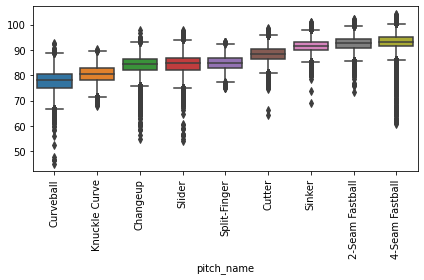

In [27]:
sorted_index = pivot_tab.median().sort_values().index
sorted_index
pivot_tab_sorted=pivot_tab[sorted_index]
sns.boxplot(data = pivot_tab_sorted )
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.tight_layout()


Analyze pitch type of all pitches above 90 miles an hour 

In [28]:
#analyze pitch type of all pitches above 90 miles an hour 
rel_speed_above_90 = df[df.release_speed > 90]
rel_speed_above_90.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,FC,2017-10-01,91.9,-1.19,5.99,"Osuna, Roberto",595885,532077,hit_into_play,...,2,2,1,1,2,Infield shift,Strategic,183.0,-0.044,-0.124
1,2350,FC,2017-10-01,91.8,-1.08,6.18,"Osuna, Roberto",595885,532077,foul,...,2,2,1,1,2,Infield shift,Strategic,164.0,-0.044,-0.035
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
4,2666,FT,2017-10-01,95.9,-0.89,6.13,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,221.0,-0.044,0.014
5,2780,FF,2017-10-01,96.0,-0.96,6.21,"Osuna, Roberto",595885,532077,called_strike,...,2,2,1,1,2,Infield shift,Strategic,203.0,-0.044,-0.018


pitch_name     
4-Seam Fastball    0.619089
2-Seam Fastball    0.216629
Sinker             0.118179
Cutter             0.029404
Slider             0.010941
Changeup           0.005238
Split-Finger       0.000494
Curveball          0.000020
Knuckle Curve      0.000006
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

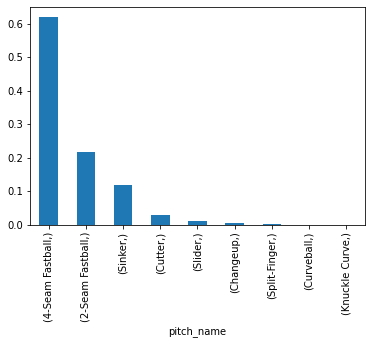

In [29]:
#print the percentages of certain pitches that are thrown at 90 mph or faster
print(rel_speed_above_90[['pitch_name']].value_counts(normalize= True))
rel_speed_above_90[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')
 

In [30]:
#what is the relationship between pitch_name and pfx_x, pfx_z since these variables are a little more complicated 
#and are not as self-explanatory

In [31]:
#what is pfx_x? It is the horizontal movement, in inches, of the pitch between the release point and home plate,
#as compared to a theoretical pitch thrown at the same speed with no spin-induced movement

In [32]:
#now that we know what pfx_x is, lets look at its relationship with pitch_name and look at its range
print(df.pfx_x.max())
print(df.pfx_x.min())

2.93
-4.15


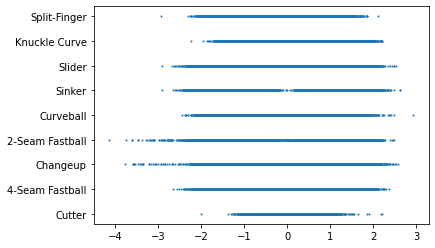

In [33]:
#lets see how the magnitude of pfx_x impacts pitch_name, generally speaking
pfx_x_col = df['pfx_x']

pitch_name_col = df['pitch_name']

plt.scatter(pfx_x_col, pitch_name_col, s=1, alpha=1)
plt.show()

In [34]:
#This helps us visualize where given pitches tend to end up on the pfx_x 'scale' 

In [35]:
pfx_x_above2 = df[df.pfx_x > 2]
print(pfx_x_above2)

        Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
2777          4102         CH  2017-10-01           80.7           2.29   
5004          3567         FT  2017-09-30           94.5           2.24   
6058          3525         SI  2017-09-30           88.2           3.76   
6061          4006         SI  2017-09-30           90.2           3.67   
6063          4309         SI  2017-09-30           89.1           3.57   
...            ...        ...         ...            ...            ...   
717292        2177         SI  2017-04-03           94.8           0.95   
717295        2468         SL  2017-04-03           79.8          -3.49   
717302        2234         SI  2017-04-03           97.1           0.80   
717306        2668         SI  2017-04-03           96.5           0.88   
717982        1167         SL  2017-04-03           79.5          -1.34   

        release_pos_z      player_name  batter  pitcher      description  ...  \
2777             6

pitch_name     
Changeup           0.240157
Sinker             0.226378
2-Seam Fastball    0.173228
Slider             0.161417
4-Seam Fastball    0.072835
Knuckle Curve      0.062992
Curveball          0.057087
Cutter             0.003937
Split-Finger       0.001969
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

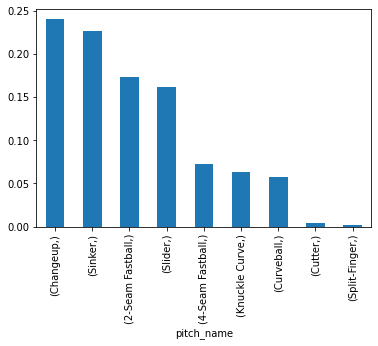

In [36]:
#all this data is for pitches with a pfx_x value of greater than 2
print(pfx_x_above2[['pitch_name']].value_counts(normalize= True))
pfx_x_above2[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

In [37]:
df_sample1 = df.sample(n=1000,replace=True)

In [38]:
print(df.release_spin_rate.max())
print(df.release_spin_rate.min())

3680.0
413.0


<function matplotlib.pyplot.legend(*args, **kwargs)>

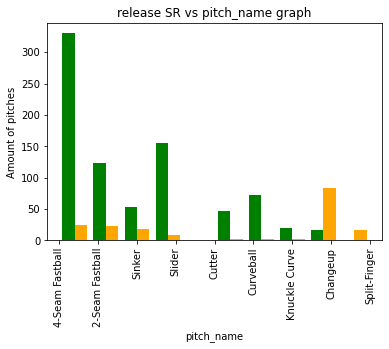

In [39]:
pitch_name_release_spin_rate_under_2000 = df_sample1[df_sample1.release_spin_rate < 2000].pitch_name
pitch_name_release_spin_rate_over_2000 = df_sample1[df_sample1.release_spin_rate > 2000].pitch_name

plt.xlabel('pitch_name')
plt.ylabel('Amount of pitches')
plt.title('release SR vs pitch_name graph')


plt.hist([pitch_name_release_spin_rate_over_2000, pitch_name_release_spin_rate_under_2000], color=['green', 'orange'], label=['RSR over 2000', 'RSR under 2000'])
plt.xticks(rotation=90)
plt.legend

In [40]:
#we see here that changeups and split-finger have very low spin rates comparatively
#this is only for our sample of 1000 pitches, but it gives us a good idea

In [41]:
#create database with only 4 seam fastball pitches
four_seam_fastball = df[df.pitch_name == '4-Seam Fastball']

In [42]:
#lets assess the typical ax value four a four seam fastball 
#ax value is the acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
four_seam_fastball.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
5,2780,FF,2017-10-01,96.0,-0.96,6.21,"Osuna, Roberto",595885,532077,called_strike,...,2,2,1,1,2,Infield shift,Strategic,203.0,-0.044,-0.018
8,3056,FF,2017-10-01,96.7,-0.64,6.26,"Osuna, Roberto",407812,532077,foul,...,2,2,1,1,2,Standard,Standard,204.0,0.000,0.000
9,3148,FF,2017-10-01,95.6,-0.87,6.16,"Osuna, Roberto",407812,532077,called_strike,...,2,2,1,1,2,Standard,Standard,212.0,0.000,-0.045
10,3330,FF,2017-10-01,95.4,-1.06,6.13,"Osuna, Roberto",407812,532077,swinging_strike,...,2,2,1,1,2,Standard,Standard,205.0,0.000,-0.032


In [43]:
four_seam_fastball['ax'].mean()

-4.827034304602974

In [44]:
#so on the mean ax value 
#(The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet)
#four all 4-seam fastballs is -4.827034304602899

In [45]:
print(four_seam_fastball['release_pos_z'].mean())
print(four_seam_fastball['release_speed'].mean())

5.956987308593735
93.24059038958636


In [46]:
#average 4-seam fastball velocity is 93.24 mph and 
#release_pos_z or (Vertical Release Position of the ball measured in feet from the catcher's perspective) is 5.96 feet

## 6. Build Model and explain the performance

In [47]:
X_new.columns

Index(['release_speed', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_z', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis'],
      dtype='object')

In [48]:
a = ['a','b']
c = ['c','d']
a+c

['a', 'b', 'c', 'd']

In [49]:
categorical_cols = ['batter','player_name','description']
numerical_cols = list(X_new)
X = df[categorical_cols + numerical_cols]
X = pd.get_dummies(X)
X

,release_speed,release_pos_z,pfx_x,pfx_z,plate_z,vy0,vz0,ax,ay,az,...,description_bunt_foul_tip,description_called_strike,description_foul,description_foul_bunt,description_foul_tip,description_hit_by_pitch,description_hit_into_play,description_missed_bunt,description_swinging_strike,description_swinging_strike_blocked
0,91.9,5.99,-0.06,1.54,3.25,-133.402168,-4.296699,-1.171849,29.813786,-13.377620,...,0,0,0,0,0,0,1,0,0,0
1,91.8,6.18,0.31,1.17,2.88,-133.448994,-4.998474,3.013840,26.852669,-17.455348,...,0,0,1,0,0,0,0,0,0,0
2,94.7,6.34,-0.27,1.84,2.76,-137.339686,-7.658337,-4.705145,30.210926,-7.569305,...,0,0,0,0,0,0,0,0,0,0
3,82.8,6.06,-1.27,1.38,0.80,-120.061310,-8.130244,-13.056935,22.889681,-17.553809,...,0,0,0,0,0,0,0,0,0,0
4,95.9,6.13,-1.19,1.50,0.87,-139.098671,-11.627566,-16.153705,30.503077,-10.366847,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721239,98.4,5.15,-1.28,0.68,1.83,-142.581131,-4.918857,-18.573869,33.201434,-22.306689,...,0,1,0,0,0,0,0,0,0,0
721240,84.6,5.39,1.10,-0.17,1.94,-122.821485,-1.341576,10.331882,24.074272,-33.798336,...,0,0,0,0,0,0,1,0,0,0
721241,97.3,5.18,-1.34,0.55,1.33,-141.192269,-5.944415,-18.881798,30.681296,-23.942620,...,0,0,0,0,0,0,0,0,0,0
721242,95.9,5.48,-1.59,0.84,2.32,-139.217803,-4.486852,-21.233172,30.974374,-20.788933,...,0,0,1,0,0,0,0,0,0,0


In [50]:
y = df.pitch_name
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

In [51]:
knn_model = KNeighborsRegressor(n_neighbors=3)
# cv_score = cross_val_score(knn_model,X_train,y_train, cv =5).mean()
# print(cv_score)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

KNN model is quiet slow for this case. So based on the scikit learn algorithm cheat sheet, since our data has more than 100k of data point, we proceed with SGD Classifier.

In [ ]:
sgd.fit(X_train, y_train)


In [ ]:
ypred = sgd.predict(X_test)